# Copyright
<pre>
This notebook was created as part of the "Deep learning / VITMMA19" class at
Budapest University of Technology and Economics, Hungary,
https://portal.vik.bme.hu/kepzes/targyak/VITMMA19

Any re-use or publication of any part of the notebook is only allowed with the  written consent of the authors.

2023 (c) Tamás Gábor Csapó (csapot kukac tmit pont bme pont hu)


Original GAN example from:

Links:
[Keras-GAN] https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
</pre>


In [ ]:
# original example from https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [ ]:
from tensorflow import keras

In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.models import Sequential, Model

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class GAN_image():

  # Discriminator network: image to binary decision,
  # result: real or fake
  def build_discriminator(self):
    model = Sequential()

    model.add(Flatten(input_shape = self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation = 'sigmoid'))

    model.summary()

    img = Input(shape=self.img_shape)

    validity = model(img)

    return Model(img, validity)

  # generator network: generating images from noise
  def build_generator(self):
    model = Sequential()

    model.add(Dense(256, input_dim = self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8)) # BatchNorm: see pres
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))

    model.summary()

    noise = Input(shape=(self.latent_dim,))
    img = model(noise)

    return Model(noise, img)


  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    # latent dimension: size of internal representation
    self.latent_dim = 100

    optimizer = keras.optimizers.Adam(0.0002, 0.5)

    # discmininator build and compile
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss = 'binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])

    # generator build
    self.generator = self.build_generator()

    # generator: produces an image from noise input
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)

    # shared/joint model - only the generator is trained here
    # (the discriminator has already been built above,
    # so the discriminator in the shared network will not be trainable)
    self.discriminator.trainable = False

    # discriminator: decides whether generated images are real or not
    validity = self.discriminator(img)

    # shared/joint model
    # goal: the generator learns how to fool the discriminator
    self.combined = Model(z, validity)
    self.combined.compile(loss = 'binary_crossentropy',
                         optimizer=optimizer)




In [ ]:
# training parameters
steps = 30000
batch_size = 128
sample_interval = 50

In [ ]:
# the first summary is for the discriminator network,
# (image -> binary decision)
# the second summary is for the generator network
# (sampled noise -> image)

gan = GAN_image()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-trai

In [ ]:
# loading data (no labels required)
from keras.datasets import mnist
(x_train, _), (_, _) = mnist.load_data()

# scaling between -1 and 1
x_train = x_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis = 3)

# discriminator outputs
valid = np.ones((batch_size, 1)) # D(x)    = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0


In [ ]:
# drawing generated images

from IPython import display

def plot_images(gan, step):
  r, c = 2,5
  noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)

  # rescaling: 0-1 (from -1 -- 1)
  gen_imgs = 0.5 * gen_imgs + 0.5

  plt.title('step ' + str(step))
  fig, ax = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      ax[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      ax[i,j].axis('off')
      cnt += 1

  display.display(plt.gcf())


4/4 [==============================] - 1s 3ms/step
0 loss_D 0.8304998278617859 loss_G 0.8149124383926392
1/1 [==============================] - 0s 96ms/step


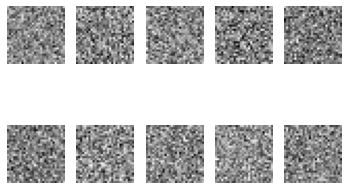

4/4 [==============================] - 0s 3ms/step
100 loss_D 0.17990602552890778 loss_G 3.7367770671844482
1/1 [==============================] - 0s 15ms/step


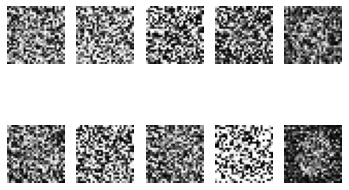

4/4 [==============================] - 0s 3ms/step
200 loss_D 0.4049694389104843 loss_G 2.279392719268799
1/1 [==============================] - 0s 13ms/step


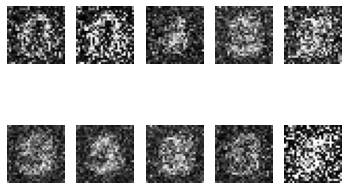

4/4 [==============================] - 0s 4ms/step
300 loss_D 0.6547281593084335 loss_G 0.6379912495613098
1/1 [==============================] - 0s 14ms/step


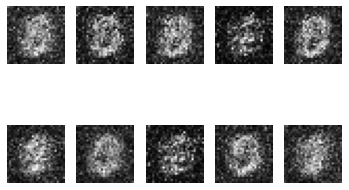

4/4 [==============================] - 0s 4ms/step
400 loss_D 0.6445320844650269 loss_G 0.6805095076560974
1/1 [==============================] - 0s 15ms/step


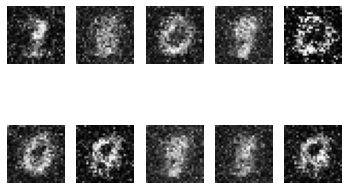

4/4 [==============================] - 0s 4ms/step
500 loss_D 0.6390110850334167 loss_G 0.7180405855178833
1/1 [==============================] - 0s 15ms/step


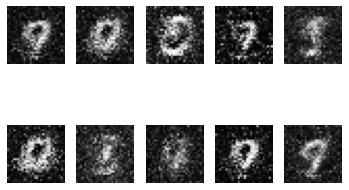

4/4 [==============================] - 0s 4ms/step
600 loss_D 0.6295639872550964 loss_G 0.7804439663887024
1/1 [==============================] - 0s 15ms/step


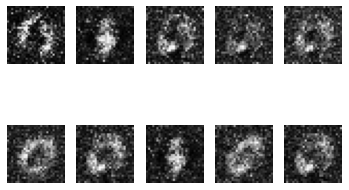

4/4 [==============================] - 0s 4ms/step
700 loss_D 0.6278464198112488 loss_G 0.845542311668396
1/1 [==============================] - 0s 16ms/step


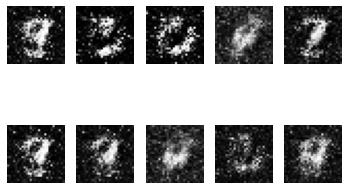

4/4 [==============================] - 0s 5ms/step
800 loss_D 0.6035338938236237 loss_G 0.8692033886909485
1/1 [==============================] - 0s 14ms/step


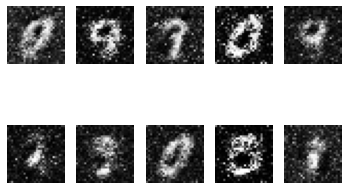

4/4 [==============================] - 0s 8ms/step
900 loss_D 0.5789910554885864 loss_G 0.9427782297134399
1/1 [==============================] - 0s 16ms/step


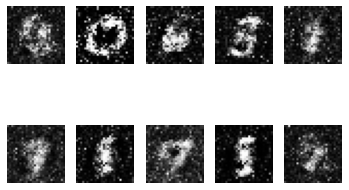

4/4 [==============================] - 0s 5ms/step
1000 loss_D 0.5809554755687714 loss_G 1.012242078781128
1/1 [==============================] - 0s 22ms/step


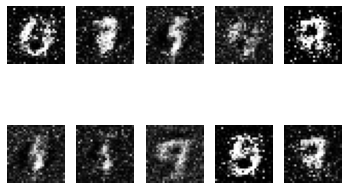

4/4 [==============================] - 0s 4ms/step
1100 loss_D 0.5290553569793701 loss_G 1.137817144393921
1/1 [==============================] - 0s 16ms/step


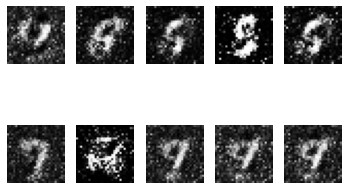

4/4 [==============================] - 0s 5ms/step
1200 loss_D 0.555680125951767 loss_G 1.0722706317901611
1/1 [==============================] - 0s 14ms/step


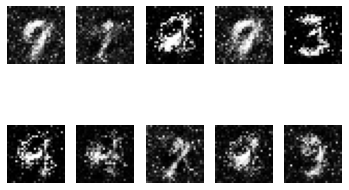

4/4 [==============================] - 0s 4ms/step
1300 loss_D 0.5565435588359833 loss_G 1.1016554832458496
1/1 [==============================] - 0s 16ms/step


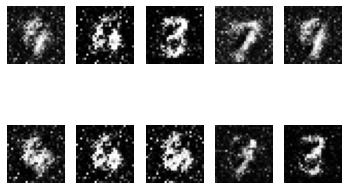

4/4 [==============================] - 0s 5ms/step
1400 loss_D 0.5380918234586716 loss_G 1.1324135065078735
1/1 [==============================] - 0s 18ms/step


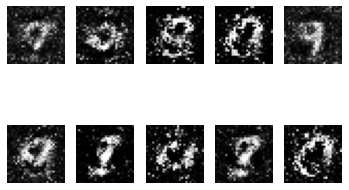

4/4 [==============================] - 0s 4ms/step
1500 loss_D 0.5339407622814178 loss_G 1.128894567489624
1/1 [==============================] - 0s 19ms/step


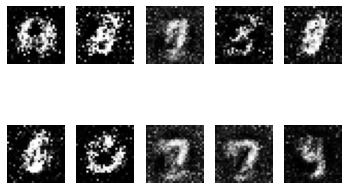

4/4 [==============================] - 0s 3ms/step
1600 loss_D 0.5609224587678909 loss_G 1.1408765316009521
1/1 [==============================] - 0s 17ms/step


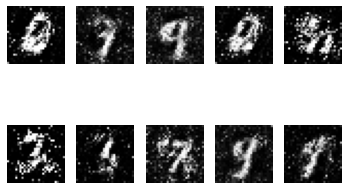

4/4 [==============================] - 0s 3ms/step
1700 loss_D 0.5396474301815033 loss_G 1.0455231666564941
1/1 [==============================] - 0s 19ms/step


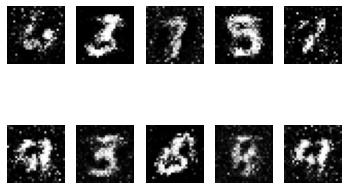

4/4 [==============================] - 0s 6ms/step
1800 loss_D 0.598531037569046 loss_G 1.038217544555664
1/1 [==============================] - 0s 20ms/step


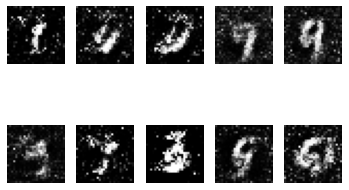

4/4 [==============================] - 0s 5ms/step
1900 loss_D 0.574816882610321 loss_G 1.0587536096572876
1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


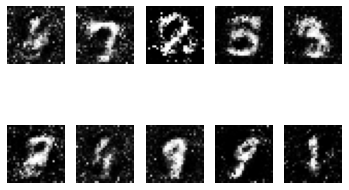

4/4 [==============================] - 0s 6ms/step
2000 loss_D 0.5736609995365143 loss_G 1.020687460899353
1/1 [==============================] - 0s 25ms/step


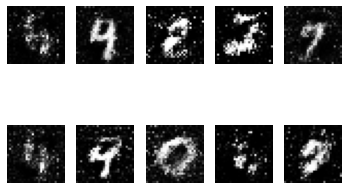

4/4 [==============================] - 0s 7ms/step
2100 loss_D 0.6203729510307312 loss_G 0.9784195423126221
1/1 [==============================] - 0s 16ms/step


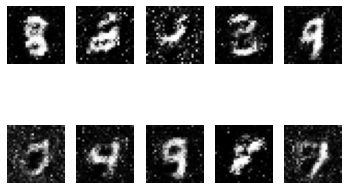

4/4 [==============================] - 0s 3ms/step
2200 loss_D 0.6322811245918274 loss_G 0.949593186378479
1/1 [==============================] - 0s 18ms/step


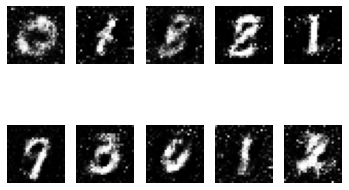

4/4 [==============================] - 0s 5ms/step
2300 loss_D 0.607562392950058 loss_G 0.9438557624816895
1/1 [==============================] - 0s 26ms/step


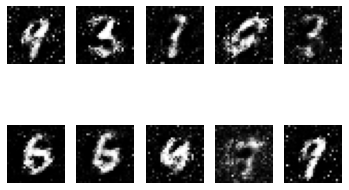

4/4 [==============================] - 0s 7ms/step
2400 loss_D 0.5925166010856628 loss_G 0.9610808491706848
1/1 [==============================] - 0s 15ms/step


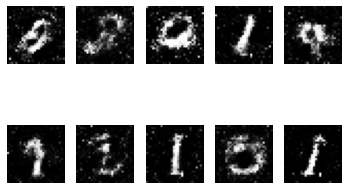

4/4 [==============================] - 0s 5ms/step
2500 loss_D 0.5725338757038116 loss_G 0.9428920745849609
1/1 [==============================] - 0s 23ms/step


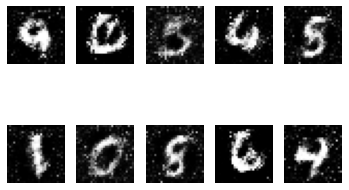

4/4 [==============================] - 0s 4ms/step
2600 loss_D 0.6358433961868286 loss_G 0.9153518676757812
1/1 [==============================] - 0s 15ms/step


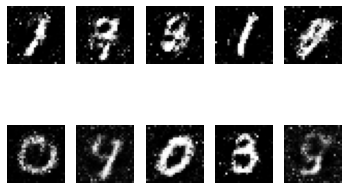

4/4 [==============================] - 0s 3ms/step
2700 loss_D 0.6031143963336945 loss_G 0.9202191829681396
1/1 [==============================] - 0s 17ms/step


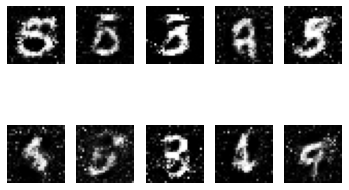

4/4 [==============================] - 0s 4ms/step
2800 loss_D 0.5978774428367615 loss_G 0.9504040479660034
1/1 [==============================] - 0s 31ms/step


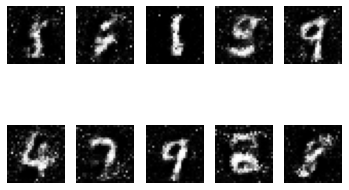

4/4 [==============================] - 0s 3ms/step
2900 loss_D 0.5808710157871246 loss_G 0.9089416265487671
1/1 [==============================] - 0s 18ms/step


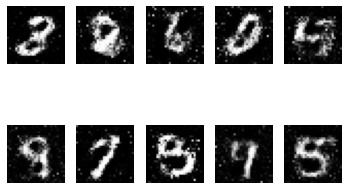

4/4 [==============================] - 0s 4ms/step
3000 loss_D 0.6249864995479584 loss_G 0.8812675476074219
1/1 [==============================] - 0s 15ms/step


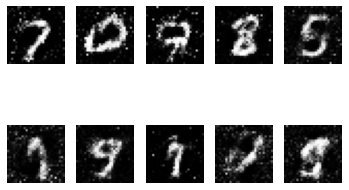

4/4 [==============================] - 0s 6ms/step
3100 loss_D 0.6051973402500153 loss_G 0.9449164271354675
1/1 [==============================] - 0s 18ms/step


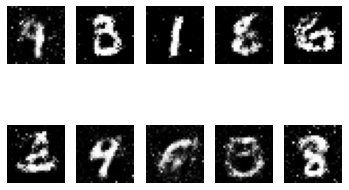

4/4 [==============================] - 0s 6ms/step
3200 loss_D 0.6365273296833038 loss_G 0.9097087383270264
1/1 [==============================] - 0s 19ms/step


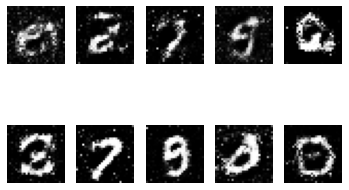

4/4 [==============================] - 0s 8ms/step
3300 loss_D 0.6207364797592163 loss_G 0.9209432601928711
1/1 [==============================] - 0s 22ms/step


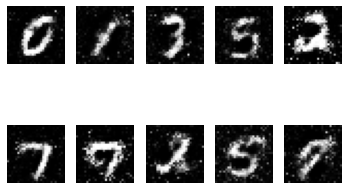

4/4 [==============================] - 0s 5ms/step
3400 loss_D 0.5967917144298553 loss_G 0.9200141429901123
1/1 [==============================] - 0s 32ms/step


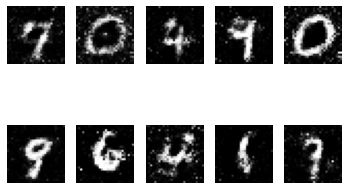

4/4 [==============================] - 0s 9ms/step
3500 loss_D 0.6299217343330383 loss_G 0.9054672718048096
1/1 [==============================] - 0s 17ms/step


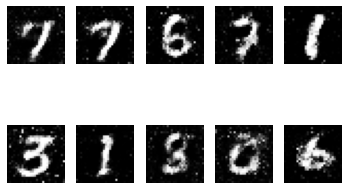

4/4 [==============================] - 0s 6ms/step
3600 loss_D 0.6192139983177185 loss_G 0.9033727645874023
1/1 [==============================] - 0s 21ms/step


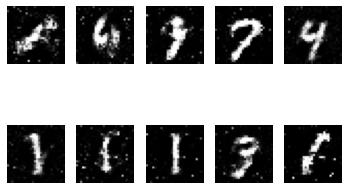

4/4 [==============================] - 0s 6ms/step
3700 loss_D 0.6591941714286804 loss_G 0.9025176167488098
1/1 [==============================] - 0s 20ms/step


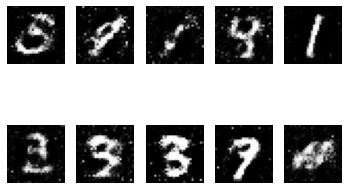

4/4 [==============================] - 0s 7ms/step
3800 loss_D 0.623679906129837 loss_G 0.8799548149108887
1/1 [==============================] - 0s 28ms/step


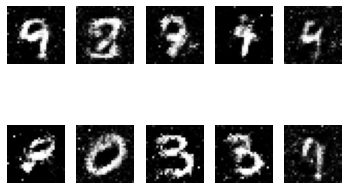

4/4 [==============================] - 0s 5ms/step
3900 loss_D 0.6586095690727234 loss_G 0.8789411187171936
1/1 [==============================] - 0s 21ms/step


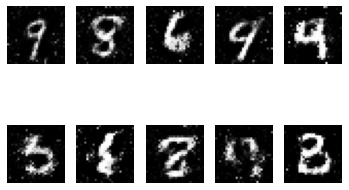

4/4 [==============================] - 0s 6ms/step
4000 loss_D 0.6308233439922333 loss_G 0.9103819131851196
1/1 [==============================] - 0s 19ms/step


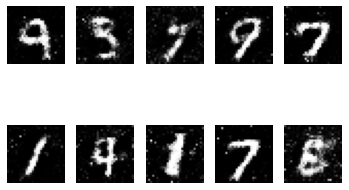

4/4 [==============================] - 0s 4ms/step
4100 loss_D 0.635997086763382 loss_G 0.9003357291221619
1/1 [==============================] - 0s 19ms/step


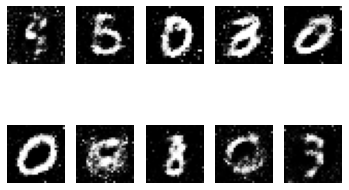

4/4 [==============================] - 0s 4ms/step
4200 loss_D 0.634877473115921 loss_G 0.9130533337593079
1/1 [==============================] - 0s 17ms/step


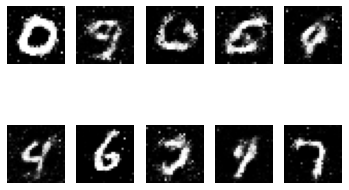

4/4 [==============================] - 0s 6ms/step
4300 loss_D 0.6323065161705017 loss_G 0.8932844400405884
1/1 [==============================] - 0s 19ms/step


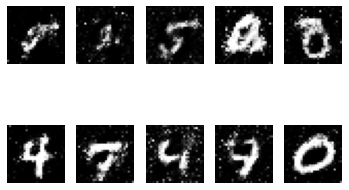

4/4 [==============================] - 0s 4ms/step
4400 loss_D 0.6610383093357086 loss_G 0.9043764472007751
1/1 [==============================] - 0s 20ms/step


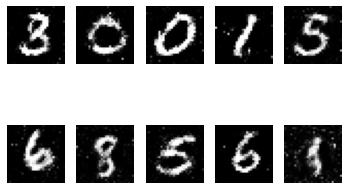

4/4 [==============================] - 0s 4ms/step
4500 loss_D 0.6320605874061584 loss_G 0.8719883561134338
1/1 [==============================] - 0s 14ms/step


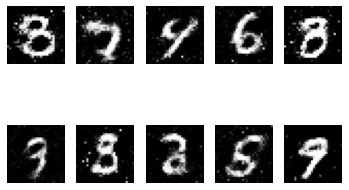

4/4 [==============================] - 0s 3ms/step
4600 loss_D 0.6689718961715698 loss_G 0.8817344903945923
1/1 [==============================] - 0s 14ms/step


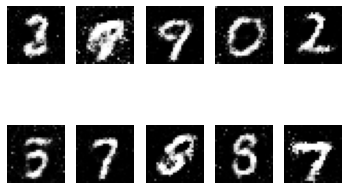

4/4 [==============================] - 0s 4ms/step
4700 loss_D 0.6496717929840088 loss_G 0.8924579620361328
1/1 [==============================] - 0s 21ms/step


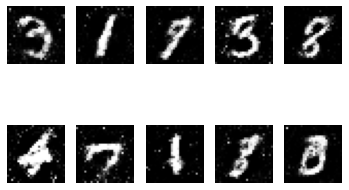

4/4 [==============================] - 0s 3ms/step
4800 loss_D 0.6593122780323029 loss_G 0.8956021070480347
1/1 [==============================] - 0s 24ms/step


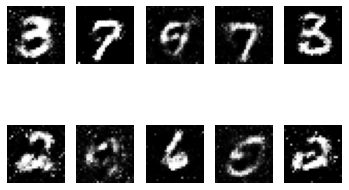

4/4 [==============================] - 0s 5ms/step
4900 loss_D 0.6723468005657196 loss_G 0.85492342710495
1/1 [==============================] - 0s 23ms/step


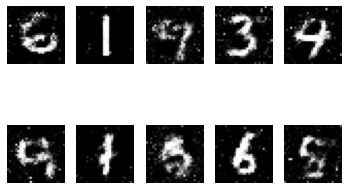

4/4 [==============================] - 0s 5ms/step


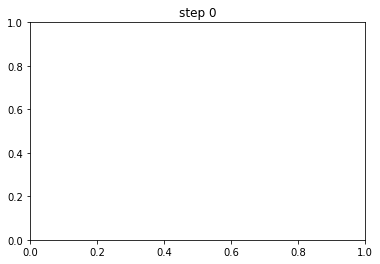

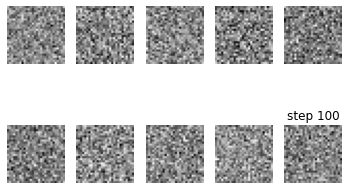

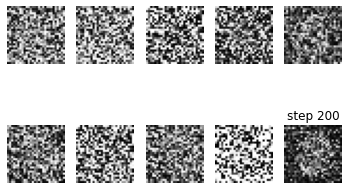

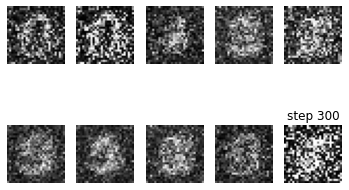

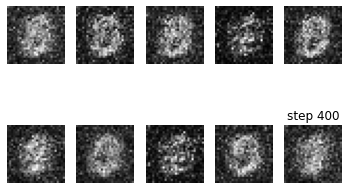

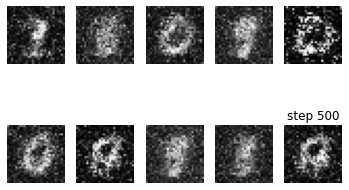

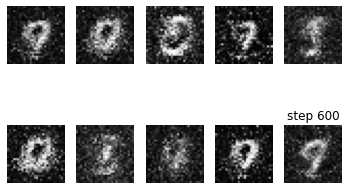

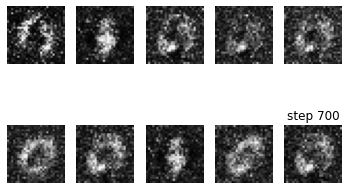

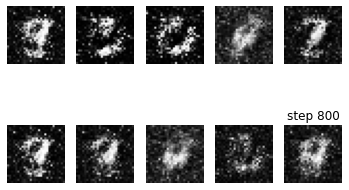

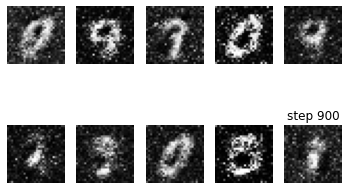

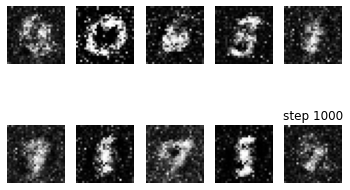

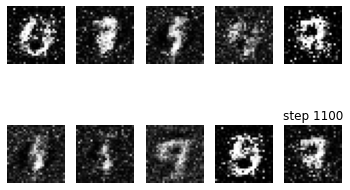

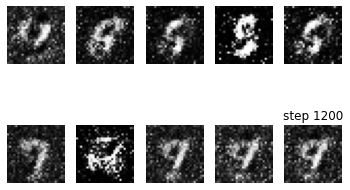

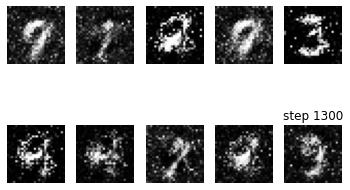

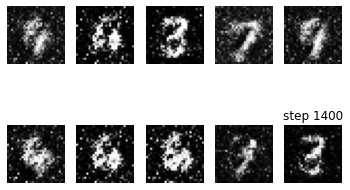

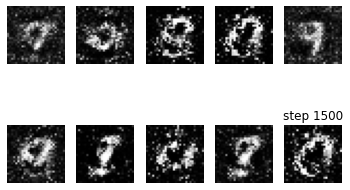

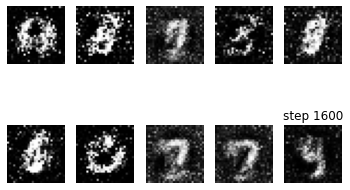

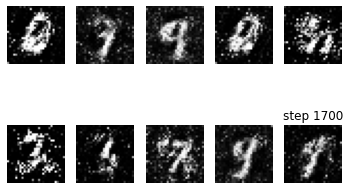

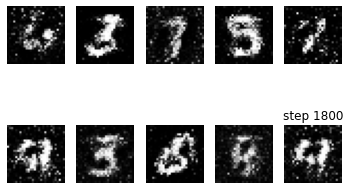

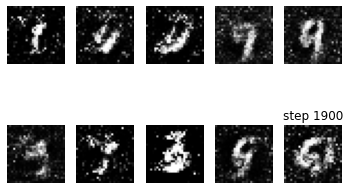

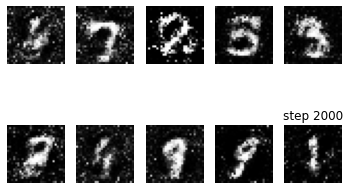

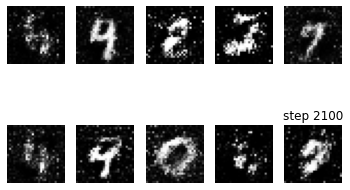

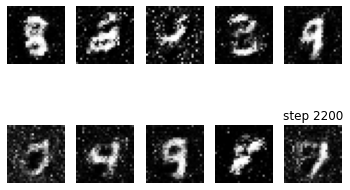

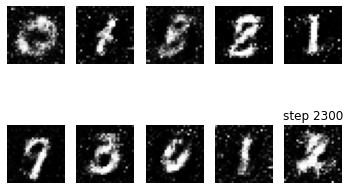

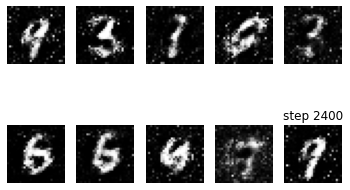

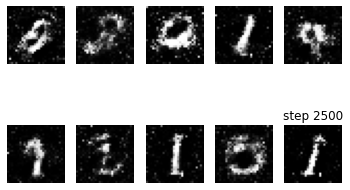

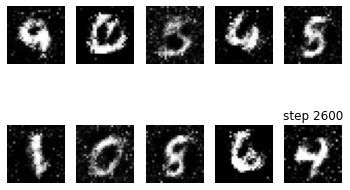

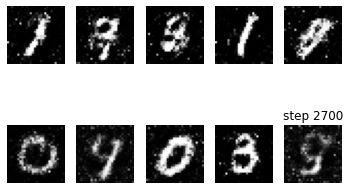

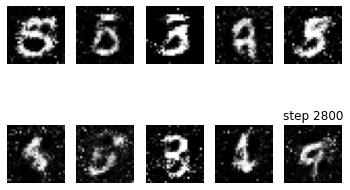

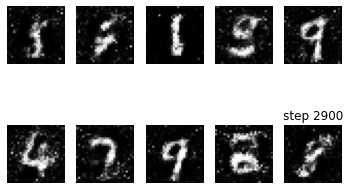

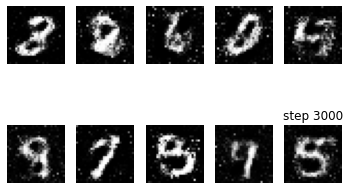

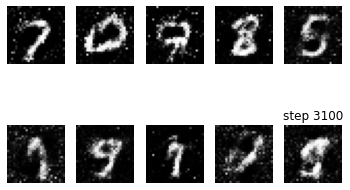

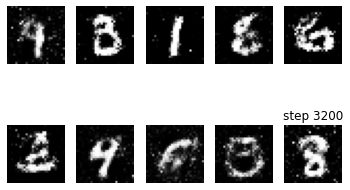

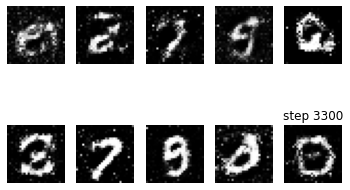

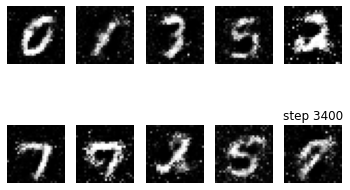

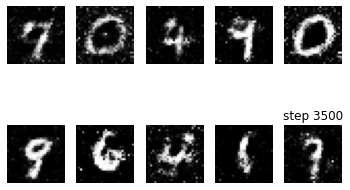

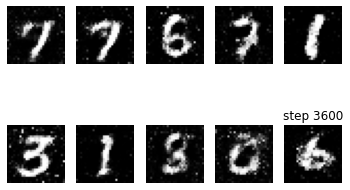

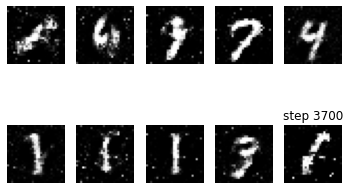

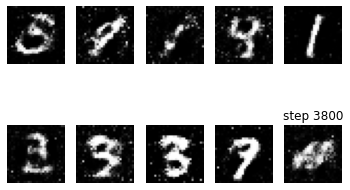

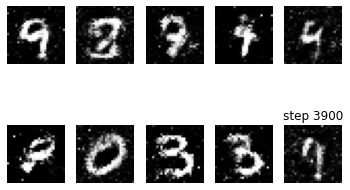

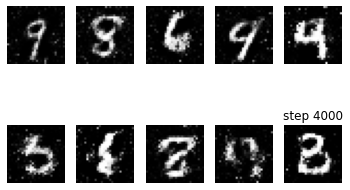

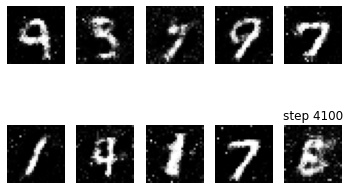

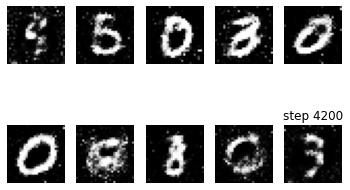

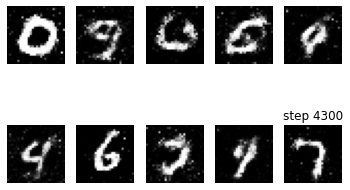

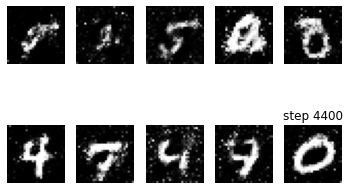

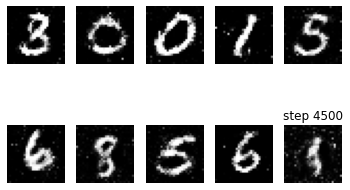

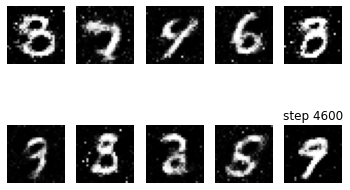

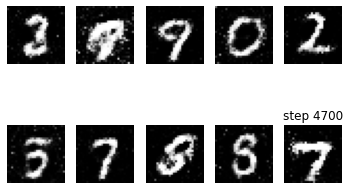

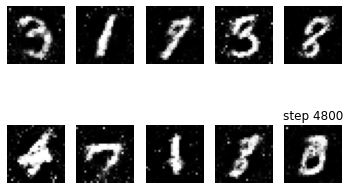

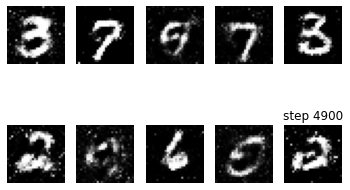

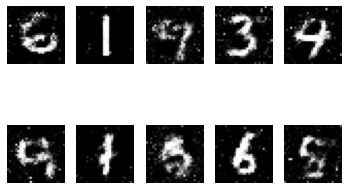

In [ ]:
# training G and D, together with plotting

for step in range(5000):

  # select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]


  # generate a batch of images
  noise = np.random.normal(0, 1, (batch_size, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise)

  # train the discriminator
  d_loss_real = gan.discriminator.train_on_batch(imgs, valid)
  d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # train the generator
  g_loss = gan.combined.train_on_batch(noise, valid)

  # log
  if step % 100 == 0:
    print(step, 'loss_D', d_loss[0], 'loss_G', g_loss)

  # draw the generated images
  if step % 100 == 0:
    plot_images(gan, step)


1/1 [==============================] - 0s 26ms/step


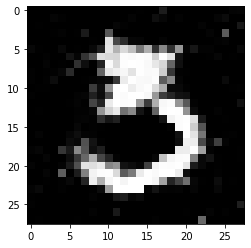

In [ ]:
# Generate 1 digit (can be repeated several times)
# may be compared with the previous VAE generated example
noise = np.random.normal(0, 1, (1, gan.latent_dim))
gen_img = gan.generator.predict(noise)
plt.imshow(gen_img.squeeze(), cmap='gray')

1/1 [==============================] - 0s 16ms/step


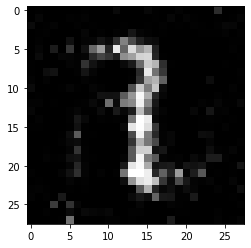

In [ ]:
# Generate 1 digit (can be repeated several times)
# may be compared with the previous VAE generated example
noise = np.random.normal(0, 1, (1, gan.latent_dim))
gen_img = gan.generator.predict(noise)
plt.imshow(gen_img.squeeze(), cmap='gray')

In [ ]:
# This is the end.
# So this is what the basic GAN does: it can generate digits based on random noise,
# but we have no control over which digit is in the image